In [7]:
!pip install --upgrade torch torchvision torchaudio

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import StepLR

В моем решении задача сменилась на классификацию CIFAR-10. Это цветные изображения 32x32 пикселя с тремя каналами (R, G, B). Датасет CIFAR-10 значительно сложнее, содержит 10 классов (животные, предметы транспорта и т.д.).

Для CIFAR-10 используется более сложный пайплайн аугментаций и нормализаций, что помогает улучшить качество:
- RandomCrop, RandomHorizontalFlip, RandomRotation, ColorJitter: Эти аугментации увеличивают разнообразие входных данных, делая модель более устойчивой к изменениям.
- Normalize: Приведение пиксельных значений к статистически нормализованному диапазону.
- RandomErasing: Дополнительный метод регуляризации, скрывающий случайные участки изображения, что препятствует “зазубриванию” модели на конкретных пиксельных паттернах.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), value='random')
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


train_dataset = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


В вашем решении архитектура стала гораздо глубже и сложнее:
- Несколько сверточных блоков:
- Первый блок: Conv2d(3,64), Conv2d(64,128) + BatchNorm + ReLU + MaxPool + Dropout.
- Второй блок: Conv2d(128,256), Conv2d(256,512) + BatchNorm + ReLU - MaxPool + Dropout.
- Третий блок: Conv2d(512,512) + BatchNorm + ReLU + MaxPool.

Гораздо больше фильтров, что увеличивает способность модели улавливать сложные характеристики изображения.
-	Добавление BatchNorm после сверток стабилизирует распределение признаков и ускоряет обучение.
-	Применение Dropout на разных этапах снижает переобучение.
-	Классификатор стал многослойным:
Linear(51244 -> 1024 -> 512 -> 10) с ReLU и Dropout между слоями.

В итоге модель из простой CNN выросла до сложной архитектуры уровня “mini-VGG-like” или приближенной к стандартным подходам для CIFAR-10.

In [10]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.features = nn.Sequential(
            # Первый сверточный блок
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Второй сверточный блок
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),

            # Третий сверточный блок
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CIFAR10Model().to(device)


def train_model(net, train_iter, test_iter, optimizer, scheduler, num_epochs):
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        net.train()
        running_loss, correct, total = 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = net(X)
            loss = loss_fn(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X.size(0)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        train_acc = correct / total
        test_acc = evaluate_accuracy(test_iter, net, device)
        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/total:.4f}, Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}")


def evaluate_accuracy(data_iter, net, dev):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(dev), y.to(dev)
            outputs = net(X)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

Применен Scheduler (StepLR) для динамического уменьшения learning rate, что помогает выходить на более высокую точность.

Учебный процесс длится 80 эпох.

Добавлен Weight Decay (L2-регуляризация), что служит дополнительной мерой против переобучения.

In [11]:
lr, num_epochs = 0.01, 80
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_model(model, train_loader, test_loader, optimizer, scheduler, num_epochs)

Epoch [1/80], Loss: 1.8927, Train Acc: 0.301, Test Acc: 0.417
Epoch [2/80], Loss: 1.4750, Train Acc: 0.459, Test Acc: 0.540
Epoch [3/80], Loss: 1.2776, Train Acc: 0.540, Test Acc: 0.583
Epoch [4/80], Loss: 1.1520, Train Acc: 0.591, Test Acc: 0.683
Epoch [5/80], Loss: 1.0589, Train Acc: 0.627, Test Acc: 0.676
Epoch [6/80], Loss: 0.9850, Train Acc: 0.655, Test Acc: 0.727
Epoch [7/80], Loss: 0.9305, Train Acc: 0.676, Test Acc: 0.754
Epoch [8/80], Loss: 0.8835, Train Acc: 0.693, Test Acc: 0.768
Epoch [9/80], Loss: 0.8431, Train Acc: 0.710, Test Acc: 0.772
Epoch [10/80], Loss: 0.7921, Train Acc: 0.728, Test Acc: 0.770
Epoch [11/80], Loss: 0.7002, Train Acc: 0.759, Test Acc: 0.819
Epoch [12/80], Loss: 0.6581, Train Acc: 0.775, Test Acc: 0.828
Epoch [13/80], Loss: 0.6323, Train Acc: 0.784, Test Acc: 0.841
Epoch [14/80], Loss: 0.6121, Train Acc: 0.790, Test Acc: 0.833
Epoch [15/80], Loss: 0.5904, Train Acc: 0.797, Test Acc: 0.842
Epoch [16/80], Loss: 0.5742, Train Acc: 0.804, Test Acc: 0.843
E

После 30-й эпохи точность на тесте стабильно держится в интервале около 90%+. К 40-й эпохе модель закрепилась на уровне 91–93% точности. Это уже очень хорошее качество для CIFAR-10.

В процессе обучения разница между точностью на трейне и тесте невелика. К финалу обучения Train Accuracy ~93.4%, Test Accuracy ~92.6%. Перепад минимален, что указывает на удачный баланс между сложностью модели и мерами регуляризации (BatchNorm, Dropout, Weight Decay).


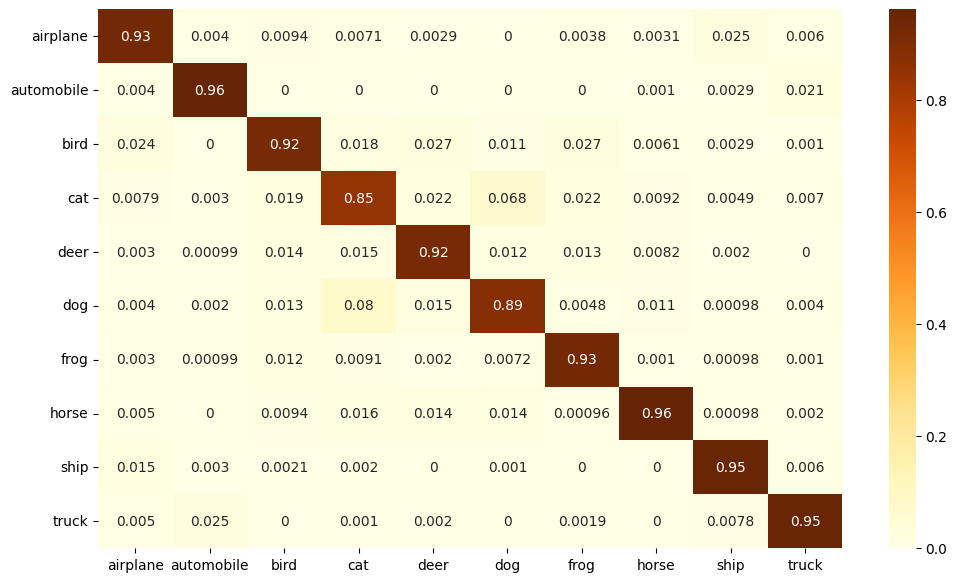

In [12]:
# Оценка результатов
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Матрица ошибок
conf_mx = confusion_matrix(y_true, y_pred, normalize='pred')
df_cm = pd.DataFrame(conf_mx, index=train_dataset.classes, columns=train_dataset.classes)
plt.figure(figsize=(12, 7))
sns.heatmap(df_cm, annot=True, cmap="YlOrBr")
plt.show()

- Высокая точность для многих классов:
Большинство классов (например, «airplane», «automobile», «frog», «horse», «ship», «truck») имеют значения на диагонали около 0.9 и выше. Это говорит о том, что модель стабильно правильно определяет эти категории, редко путая их с другими.

- Проблемная пара «cat» и «dog»:
Класс «cat» имеет точность около 0.85, что ниже, чем у большинства других классов. «dog» также иногда путается с «cat» (около 0.08). Эта ситуация закономерна, поскольку «cat» и «dog» визуально ближе друг к другу, чем, скажем, «automobile» и «frog». Это указывает на сложность различения похожих по структуре и цветам животных.

- Небольшие частичные пересечения между «bird» и другими животными:
«bird» в ряде случаев путается с «cat», «deer» и немного с другими животными. Это свидетельствует о том, что мелкие различия в текстурах и формах пернатых и прочих живых существ иногда вызывают ошибочную классификацию.

- Хорошая дифференциация неодушевленных объектов:
«automobile», «ship», «truck» и «airplane» практически не пересекаются между собой, модель уверенно различает их. Это может быть связано с их более чёткими формами, контрастными фонами.

Итог: модель очень хорошо справляется с классами, визуально и контекстуально отличающимися друг от друга, но испытывает определенные трудности при различении близких по характеристикам классов, в особенности классов животных, а также тех, которые частично могут иметь визуальное сходство. Тем не менее, даже в этих случаях ошибки ограничены относительно небольшой долей.